# 遥感影像建筑物足迹分割

**目标：**


1.   使用深度神经网络(Deep Neural network, DNN)来解决语义分割问题
2.   学习基本的DNN训练方法
3.   熟悉目前主流的深度学习框架Pytorch

本次作业我们提供了训练集、验证集（均带有标签）以及测试集（不带标签），你可以通过训练集和验证集寻找最好的模型，并在测试集上得到你的预测结果。

最后你需要将预测结果提交到kaggle上(https://www.kaggle.com/competitions/ml-dl-2022-hw2), 系统会自动返回给交并比IoU。

总的来说，本次作业的目标就是基于我们给定的代码，发挥你在课堂上学习到的知识，修改代码，从而得到尽可能低的**测试集**误差。


## 研究准备

### **下载数据**

在这里，我们从google drive上下载训练集，验证集和测试集,并将其解压到data路径

In [ ]:
!pip install imagecodecs-lite
!pip install -U --no-cache-dir gdown --pre
# 获取数据
!gdown --id 1SGxB0031J3pXsi0vq-8dvu5ONDA9Ea0a --output "data.zip"
# 解压
root = "data"
!sudo apt-get install p7zip-full
!7z x data.zip -odata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 41.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1SGxB0031J3pXsi0vq-8dvu5ONDA9Ea0a
To: /content/data.zip
100% 500M/500M [00:14<00:00, 35.7MB/s]
Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
The following package was automatically installed and is n

### **环境配置**

In [ ]:
# 如果你引入了新的库，可以从这里导入
import torch # pytorch，目前主流的深度学习框架
from torch.utils import data # 从torch.utils导入data模块，用来构建pytorch中的数据结构--->dataloader
from torch import nn # 从torch导入nn模块，用来提供基本的神经网络接口，如全连接层nn.Linear()
import numpy as np # 导入numpy，并将其重命名为np，numpy是一个高效的用来处理矩阵的库
from tqdm import tqdm # tqdm是一个可视化代码进程的模块
import skimage.io # skimage.io 可以用来读取图像
import cv2 # 用来处理图像的库
import os # os库用来处理磁盘读写过程
import csv # 读写csv文件的库
import torchvision.transforms.functional as TF # 用于进行图像变换的库
import torch.nn.functional as F
import matplotlib.pyplot as plt

# 为了处理大批量数据，在目前主流的深度学习框架下，数据都是以矩阵的形式表示的
# 而对于CPU来讲，其对于矩阵数据处理效率欠佳，而GPU(显卡）则擅长处理矩阵，因此深度学习模型都会部署到GPU上
# 这段代码的意思是，判断目前的设备中是否有安装CUDA（GPU加速模块）。
# 如果有的话，我们就让模型部署到GPU上，如果没有，我们继续用CPU（速度会慢一点）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
device

device(type='cuda')

### **数据说明**

本次作业我们的任务是从遥感影像中提取建筑物的足迹(footprint)。建筑足迹提供了沿外墙绘制的建筑轮廓，并对其基础的确切大小、形状和位置进行了描述。你也可以近似理解其为建筑物屋顶的分布。

我们提供了三波段(RGB)遥感影像(分辨率为1米),以及其对应的建筑物足迹分布,如下所示

我们可以发现，建筑物足迹分布图实际上是一个二值图，即背景的像素值为0(黑色)，建筑物区域的像素值为255(红色)。本次作业我们的任务就是，训练一个模型，这个模型的输入是影像，输出是对应的足迹分布，我们要尽可能地让这个模型的预测结果准确。


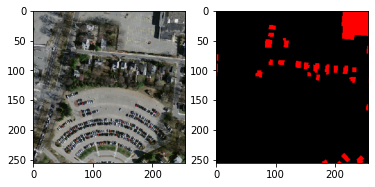

In [ ]:
# 可视化我们用于训练的遥感影像及其对应的建筑物标签
image = skimage.io.imread("/content/data/image/train/22678915_15_1_4.tiff")
label = skimage.io.imread("/content/data/label/train/22678915_15_1_4.tif")
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.imshow(image)
ax2.imshow(label)

## 进行实验

### **构建数据**

In [ ]:
def makeDataset(mode):

    all_tokens = []

    assert mode in ['train', 'val', 'test']
    image_path = os.path.join(root, "image", mode)

    if mode == "test":
      
      img_tokens = os.listdir(image_path)
      for img_token in img_tokens:
        all_tokens.append(os.path.join(image_path, img_token))
      return all_tokens
    else:
      label_path = os.path.join(root, "label", mode)

      img_tokens = os.listdir(image_path)
      img_tokens.sort()

      label_tokens = os.listdir(label_path)
      label_tokens.sort()

      assert len(img_tokens) == len(label_tokens), "The number of images is inconsistent with the number of labels"

      for img_token, label_token in zip(img_tokens, label_tokens):
          token = (os.path.join(image_path, img_token), os.path.join(label_path, label_token))
          all_tokens.append(token)

    print(f' 在{mode}阶段，我们有{len(all_tokens)}个样本')

    return all_tokens


class BuildingDataset(data.Dataset):
    def __init__(self, mode):

        self.mode = mode
        self.data_tokens = makeDataset(mode)
        assert len(self.data_tokens), "the data is empty!Please check the root"

    def __getitem__(self, index):
        token = self.data_tokens[index]
        if self.mode == "test":
          image_path = token
          image = skimage.io.imread(image_path)
          image = TF.to_pil_image(image)
          image_name = os.path.splitext(os.path.basename(image_path))[0]
          image = TF.to_tensor(image)
          image = TF.normalize(image, mean=[0.33, 0.34, 0.30], std=[0.17, 0.165, 0.17])
          return image, image_name

        else:
          image_path, label_path = token
          image, label = skimage.io.imread(image_path), skimage.io.imread(label_path)
          image = TF.to_pil_image(image)
          label = TF.to_pil_image(label)
          image_name = os.path.splitext(os.path.basename(image_path))[0]
          if self.mode in ["val"]:
              image = TF.to_tensor(image)
              label = TF.to_tensor(label)
              image = TF.normalize(image, mean=[0.33, 0.34, 0.30], std=[0.17, 0.165, 0.17]) # 图像标准化
          else:
              """
              TODO:一般来讲，增加数据多样性会提高模型的泛化性能，这一操作叫做即数据增强(data augumentation)。常用的图像增强的方法有：color jittering, roate, vflip和hflip等。
              请查阅如何用TF库实现数据增强，并在此处进行修改，来增加数据的多样性
              """
              image = TF.to_tensor(image)
              label = TF.to_tensor(label)
              image = TF.normalize(image, mean=[0.33, 0.34, 0.30], std=[0.17, 0.165, 0.17]) 
          label = label[0, :, :]
          label = torch.unsqueeze(label, 0)
          return image, label

    def __len__(self):
        return len(self.data_tokens)
    # 该函数可以用来提取建筑物的轮廓
    # 将轮廓信息，做为辅助的监督信息会提升模型对建筑物预测的精度，一种简单的设计是这样↓，即我们让模型有两个预测分支，一个是建筑物足迹掩膜（我们所需要的），另一个是建筑物边缘掩膜，并对这两个结果同时计算损失并反向传播
    #         -----> building prediction <-> building ground truth
    # image->model->
    #         -----> boundary prediction <-> boundary ground truth
    @staticmethod
    def get_boundary(mask, thicky=8): # thicky即轮廓的"厚度"
        tmp = mask.data.numpy().astype('uint8')
        tmp = tmp[0]  # 从 [1,w,h] to [w,h]
        contour, _, = cv2.findContours(tmp, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        boundary = np.zeros_like(tmp)
        boundary = cv2.drawContours(boundary, contour, -1, 1, thicky)
        boundary = boundary.astype(np.float)
        boundary = TF.to_tensor(boundary)
        return boundary

### **搭建模型**

In [ ]:
class MyCNN(nn.Module):
  """
  我们使用的模型是一个我加以改进的FCN模型, FCN(Fully Convolutional Networks)是利用卷积神经网络实现语义分割的开山之作。
  在使用这个模型的时候，请思考：
  （1）什么是语义分割？它的特点是什么？
  （2）FCN为什么这样设计？这样设计的目的是什么？
  """
  def __init__(self):
    super().__init__()
        # 第一层卷积
    self.layer1 = nn.Sequential(
        nn.Conv2d(3, 48, (3, 3), padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(48, 48, (3, 3), padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, stride=2, ceil_mode=True)  # Downsampling 1/2
    )

    # 第二层卷积
    self.layer2 = nn.Sequential(
        nn.Conv2d(48, 128, (3, 3), padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(128, 128, (3, 3), padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, stride=2, ceil_mode=True)  # Downsampling 1/4
    )

    # 第三层卷积
    self.layer3 = nn.Sequential(
        nn.Conv2d(128, 192, (3, 3), padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(192, 192, (3, 3), padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, stride=2, ceil_mode=True)  # Downsampling 1/8
    )

    # 第四层卷积
    self.layer4 = nn.Sequential(
        nn.Conv2d(192, 256, (3, 3), padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, (3, 3), padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, stride=2, ceil_mode=True)  # Downsampling 1/16
    )

    # 第五层卷积
    self.layer5 = nn.Sequential(
        nn.Conv2d(256, 512, (3, 3), padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, (3, 3), padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, stride=2, ceil_mode=True)  # Downsampling 1/32
    )

    self.score_1 = nn.Conv2d(512, 128, (1, 1))
    self.score_2 = nn.Conv2d(256, 128, (1, 1))
    self.score_3 = nn.Conv2d(192, 128, (1, 1))
    self.score_4 = nn.Conv2d(128, 128, (1, 1))

    self.final_layer = nn.Conv2d(128, 1, (1, 1))
  def forward(self,x):
    _,_,h,w = x.shape
    # 输入的图像为x，通过下面的五个layer的操作，我们发现特征的尺寸在逐渐变小，为什么我们要这么做，这样做的目的是什么？
    # (提示：从物体尺度和模型计算量角度思考）
    x1 = self.layer1(x) # (B,C,H/2,W/2)
    x2 = self.layer2(x1) # (B,C,H/4,W/4)
    x3 = self.layer3(x2) # (B,C,H/8,W/8)
    x4 = self.layer4(x3) # (B,C,H/16,W/16)
    x5 = self.layer5(x4) # (B,C,H/32,W/32)

    # 上述操作让我们的特征图尺寸逐渐变小，我们为了得到原始分辨率的预测，在这里我们逐步恢复图像分辨率
    x5 = self.score_1(x5) # 在这里，我们在恢复特征图分辨率之前，先用一个卷积进行特征提取，目的有1）保证不同尺度特征图通道数相同2）将不同尺度特征图映射到相同的特征空间，使得相加有意义。
    # 代码默认的方法是双线性插值上采样，你有更好的办法吗，如反卷积等？这些方法会提高模型的精度吗？
    x5 = F.upsample(input=x5, size=(int(h/16), int(w/16)), mode='bilinear')
    x4 = self.score_2(x4)
    x4 += x5

    x4 = F.upsample(input=x4, size=(int(h/8), int(w/8)), mode='bilinear')
    x3 = self.score_3(x3)
    x3 +=x4
    
    x3 = F.upsample(input=x3, size=(int(h/4), int(w/4)), mode='bilinear')
    x2 = self.score_4(x2)
    x2 += x3
    
    final_score = self.final_layer(x2)
    final = F.upsample(input=final_score, size=(h, w), mode='bilinear')

    return final
  
# TODO: 事实上，语义分割领域目前有非常多的网络可供选择，你会使用它们，并将它们应用到建筑物足迹提取上来吗？


### **评价方式**

在这里，我们直接提供一个评价预测结果的类，里面包含很多评价指标。这部分你不需要修改，因为这些评价指标足够本次作业的使用了

In [ ]:
class Evaluator(object):
    """
    Code is modified based on  https://github.com/jfzhang95/pytorch-deeplab-xception/blob/master/utils/metrics.py#L33
    """

    def __init__(self, num_class):
        self.num_class = num_class
        self.confusion_matrix = np.zeros((self.num_class,) * 2)

        self.TP = 0
        self.FN = 0
        self.FP = 0
        self.TN = 0

    def Pixel_Accuracy(self):
        Acc = np.diag(self.confusion_matrix).sum() / self.confusion_matrix.sum()  # (TP+TN)/(ALL)
        return Acc

    def Pixel_Accuracy_Class(self):
        Acc = np.diag(self.confusion_matrix) / self.confusion_matrix.sum(axis=1)
        Acc = np.nanmean(Acc)
        return Acc

    def Mean_Intersection_over_Union(self):
        MIoU = np.diag(self.confusion_matrix) / (
                np.sum(self.confusion_matrix, axis=1) + np.sum(self.confusion_matrix, axis=0) -
                np.diag(self.confusion_matrix))

        MIoU = np.nanmean(MIoU)

        return MIoU

    def Frequency_Weighted_Intersection_over_Union(self):
        freq = np.sum(self.confusion_matrix, axis=1) / np.sum(self.confusion_matrix)
        iu = np.diag(self.confusion_matrix) / (
                np.sum(self.confusion_matrix, axis=1) + np.sum(self.confusion_matrix, axis=0) -
                np.diag(self.confusion_matrix))

        FWIoU = (freq[freq > 0] * iu[freq > 0]).sum()
        return FWIoU

    def _generate_matrix(self, gt_image, pre_image):
        mask = (gt_image >= 0) & (gt_image < self.num_class)
        label = self.num_class * gt_image[mask].astype('int') + pre_image[mask]
        count = np.bincount(label, minlength=self.num_class ** 2)
        confusion_matrix = count.reshape(self.num_class, self.num_class)
        return confusion_matrix

    def add_batch(self, gt_image, pre_image):
        assert gt_image.shape == pre_image.shape, f"gt shape is {gt_image.shape}, while pre shape is {pre_image.shape}"

        # gt_image=gt_image.astype(np.int8)
        # pre_image = pre_image.astype(np.int8)
        self.confusion_matrix += self._generate_matrix(gt_image, pre_image)
        self.TP = self.confusion_matrix[1, 1]
        self.FN = self.confusion_matrix[1, 0]
        self.FP = self.confusion_matrix[0, 1]
        self.TN = self.confusion_matrix[0, 0]

    def F1(self):
        return (2 * self.TP) / (2 * self.TP + self.FP + self.FN)

    def Precision(self):
        return self.TP / (self.TP + self.FP)

    def Recall(self):
        return self.TP / (self.TP + self.FN)

    def OA(self):
        return (self.TP + self.TN) / (self.TP + self.FP + self.TN + self.FN)

    def IoU(self):
        """只算前景(1)类的IoU"""
        return self.TP / (self.TP + self.FP + self.FN)

    def reset(self):
        self.confusion_matrix = np.zeros((self.num_class,) * 2)

### **处理输出**

在这里，我们定义一些函数用来处理我们模型的输出：



*   rle_encoding：将预测结果（二值掩膜）进行游程长度编码，从而压缩其大小，方便大家提交到Kaggle上
*   process_output和process_testOutput：用于处理模型的输出






In [ ]:
def rle_encoding(img):
      # 游程长度编码程序
      pixels = img.T.flatten()
      pixels = np.concatenate([[0], pixels, [0]])
      runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
      runs[1::2] -= runs[::2]
      return ' '.join(str(x) for x in runs)
# 模型的输出是建筑物概率值(0-1)，我们需要二值化输出来得到最终的预测结果
def process_output(model_out,threshold=0.5): 
  model_out = torch.sigmoid(model_out) # 利用sigmoid 将预测结果转换为概率
  out_new = model_out.detach().cpu().numpy()
  out_new = np.where(out_new > threshold, 1, 0)
  return out_new

def process_testOutput(model_out,image_name,threshold=0.5): 
  model_out = torch.sigmoid(model_out) # 利用sigmoid 将预测结果转换为概率
  out_new = model_out.detach().cpu().numpy()
  out_new = np.where(out_new > threshold, 1, 0)
  out_new = out_new[0][0]
  out_new = out_new.astype(np.uint8)
  # 在这里，我们用两种方式处理预测结果
  # (1) 保存成二值图，方便我们肉眼观察
  skimage.io.imsave(f"pre/{image_name[0]}.png",out_new)
  # (2) 利用游程长度编码进行压缩，存储为csv格式，用于最终Kaggle平台上的提交
  pre_encoding = rle_encoding(out_new)
  return pre_encoding

### **训练、验证和测试**

In [ ]:
def train(train_dataset, val_dataset, config, model, evaluator):
  """训练代码"""
  n_epochs = config['n_epochs'] # 训练次数
  optimizer = getattr(torch.optim, config['optimizer'])(model.parameters(), **config['optim_hparas']) # 优化器
  model.train() # 设置模型为训练模式（梯度可以回传）
  pbar = tqdm(total=n_epochs, desc="Train Mode", unit="epoch") 
  loss = nn.BCEWithLogitsLoss() # 损失函数为二分类交叉熵
  loss_log = {"train_loss": [], "val_loss": []}
  iou_log =  {"train_iou": [], "val_iou": []}
  f1_log = {"train_f1": [], "val_f1": []}
  oa_log = {"train_oa": [], "val_oa": []}
  best_accuracy = 0.0
  best_state_dict = None
  for epoch in range(n_epochs):
      pbar.update()
      epoch_loss = 0.0
      for i,(x, label) in enumerate(train_dataset):
          optimizer.zero_grad() # 将优化器里储存的梯度清零
          x, label = x.to(device).float(), label.to(device).float()
          pred = model(x)
          ce_loss = loss(pred, label) # 计算损失
          batch_loss = ce_loss.detach().cpu().item()
          ce_loss.backward() # 损失回传
          optimizer.step() # 梯度更新
          loss_log["train_loss"].append(ce_loss.detach().cpu().item())
          epoch_loss += ce_loss.detach().cpu().item()
          pred_processed = process_output(pred)
          evaluator.add_batch(label.detach().cpu().numpy(), pred_processed)
          pbar.set_postfix(
              batch=f"{i}/{len(train_dataset)}",
              batch_loss=f"{batch_loss:.4f}",
              epoch=epoch+1
          )
      IoU = evaluator.IoU()
      OA = evaluator.OA()
      F1 = evaluator.F1()
      f1_log["train_f1"].append(F1)
      oa_log["train_oa"].append(OA)
      iou_log["train_iou"].append(IoU)
      pbar.set_postfix(
          epoch_sum_loss=f"{epoch_loss:.4f}",
          epoch_IoU=f"{IoU:.4f}",
          epoch_OA=f"{OA:.4f}",
          epoch_F1=f"{F1:.4f}",
          epoch=epoch + 1
      )
      evaluator.reset()
      pbar.close()
      val_loss, val_IoU, val_OA, val_F1 = val(val_dataset, model, evaluator)
      loss_log["val_loss"].append(val_loss)
      f1_log["val_f1"].append(val_F1)
      oa_log["val_oa"].append(val_OA)
      iou_log["val_iou"].append(val_IoU)
      if val_IoU>best_accuracy:
          best_accuracy = val_IoU
          best_state_dict = model.state_dict()
      pbar = tqdm(total=n_epochs, desc="Train Mode", unit="step", initial=epoch + 1)  # 重启 pbar
      if best_state_dict is not None:
          torch.save(best_state_dict, config["save_path"] + ".ckpt")
          pbar.write(f"epoch {epoch + 1}, best model saved. (accuracy={best_accuracy:.4f})")
          best_state_dict = None
  return loss_log, iou_log,oa_log,f1_log,best_accuracy

def val(dataloader,model,evaluator):
  """验证代码"""
  model.eval()
  pbar = tqdm(total=len(dataloader.dataset), ncols=0, desc="Valid Mode", unit=" uttr")
  loss = nn.BCEWithLogitsLoss() # 损失函数为二分类交叉熵
  total_loss = 0.0
  for i, (x,label) in enumerate(dataloader):
      with torch.no_grad():
          x, label = x.to(device).float(), label.to(device).float()
          pred = model(x)
          pred_processed = process_output(pred)
          ce_loss = loss(pred,label)
          total_loss += ce_loss.detach().cpu().item()
          evaluator.add_batch(label.detach().cpu().numpy(), pred_processed)
      pbar.update(dataloader.batch_size)
  IoU = evaluator.IoU()
  OA = evaluator.OA()
  F1 = evaluator.F1()
  pbar.set_postfix(
      loss=f"{total_loss :.4f}",
      IoU=f"{IoU :.4f}",
      OA=f"{OA :.4f}",
      F1=f"{F1 :.4f}",
  )
  evaluator.reset()
  pbar.close()
  model.train()

  return total_loss / len(dataloader), IoU, OA, F1

def test(dataloader,model):
  """测试代码"""
  model.eval()
  pbar = tqdm(total=len(dataloader.dataset), ncols=0, desc="Valid Mode", unit=" uttr")
  header = ["ImageId", "EncodedPixels"]
  with open("pred.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(header)
    for i, (x,image_name) in enumerate(dataloader):
      with torch.no_grad():
        x = x.to(device).float()
        pred = model(x)
        pre_encoding = process_testOutput(pred,image_name)
        in_data = [image_name[0], pre_encoding]
        writer.writerow(in_data)
      pbar.update(1)

### 主程序

In [ ]:
model = None
os.makedirs('models', exist_ok=True)
os.makedirs('pre',exist_ok=True)
# 超参数的设置
config = {
    'n_epochs': 100,  # 训练次数
    'batch_size': 8,  # mini-batch 的大小 
    'optimizer': 'SGD',  # 优化算法 (optimizer in torch.optim) 
    'optim_hparas': {  # 优化器的超参数(取决于你用了什么优化算法)
        'lr': 0.001,
        'momentum':0.9               # SGD的学习率  # SGD的动量
    },
    'save_path': 'models/model.pth'  # 存储路径
}
# 构建dataset
train_set = BuildingDataset("train")
val_set = BuildingDataset("val")
test_set = BuildingDataset("test")

train_loader = data.DataLoader(train_set,batch_size = config["batch_size"], num_workers = 1)
val_loader = data.DataLoader(val_set,batch_size = config["batch_size"], num_workers = 1)
test_loader = data.DataLoader(test_set,batch_size = 1, shuffle=False, num_workers = 1) 

# 实例化模型
model = MyCNN().to(device)
evaluator = Evaluator(num_class=2)
# 开始训练与验证
result = train(train_loader, val_loader, config, model,evaluator)



 在train阶段，我们有1350个样本
 在val阶段，我们有540个样本


Train Mode:   0%|          | 0/100 [00:00<?, ?epoch/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
Train Mode:   1%|          | 1/100 [00:27<45:15, 27.42s/epoch, epoch=1, epoch_F1=0.0378, epoch_IoU=0.0192, epoch_OA=0.8269, epoch_sum_loss=83.2719]
Valid Mode: 544 uttr [00:05, 106.18 uttr/s, F1=0.0000, IoU=0.0000, OA=0.8639, loss=27.8098]
Train Mode:   2%|▏         | 2/100 [00:20<32:41, 20.01s/step, epoch=2, epoch_F1=0.0000, epoch_IoU=0.0000, epoch_OA=0.8688, epoch_sum_loss=66.3071]
Valid Mode: 544 uttr [00:05, 105.58 uttr/s, F1=0.0000, IoU=0.0000, OA=0.8639, loss=27.3184]
Train Mode:   3%|▎         | 3/100 [00:20<32:51, 20.32s/step, epoch=3, epoch_F1=0.0000, epoch_IoU=0.0000, epoch_OA=0.8688, epoch_sum_loss=65.3047]
Valid Mode: 544 uttr [00:05, 106.11 uttr/s, F1=0.0000, IoU=0.0000,

epoch 8, best model saved. (accuracy=0.0000)


Train Mode:   9%|▉         | 9/100 [00:21<32:47, 21.62s/step, epoch=9, epoch_F1=0.1137, epoch_IoU=0.0603, epoch_OA=0.8731, epoch_sum_loss=51.1830]
Valid Mode: 544 uttr [00:05, 104.01 uttr/s, F1=0.0221, IoU=0.0112, OA=0.8648, loss=23.4217]
Train Mode:   9%|▉         | 9/100 [00:00<?, ?step/s]

epoch 9, best model saved. (accuracy=0.0112)


Train Mode:  10%|█         | 10/100 [00:21<32:22, 21.58s/step, epoch=10, epoch_F1=0.3003, epoch_IoU=0.1767, epoch_OA=0.8801, epoch_sum_loss=48.9391]
Valid Mode: 544 uttr [00:05, 105.61 uttr/s, F1=0.0768, IoU=0.0399, OA=0.8678, loss=22.7254]
Train Mode:  10%|█         | 10/100 [00:00<?, ?step/s]

epoch 10, best model saved. (accuracy=0.0399)


Train Mode:  11%|█         | 11/100 [00:21<31:55, 21.53s/step, epoch=11, epoch_F1=0.3767, epoch_IoU=0.2321, epoch_OA=0.8850, epoch_sum_loss=47.5381]
Valid Mode: 544 uttr [00:05, 103.77 uttr/s, F1=0.1468, IoU=0.0792, OA=0.8718, loss=22.0562]
Train Mode:  11%|█         | 11/100 [00:00<?, ?step/s]

epoch 11, best model saved. (accuracy=0.0792)


Train Mode:  12%|█▏        | 12/100 [00:21<31:37, 21.57s/step, epoch=12, epoch_F1=0.4153, epoch_IoU=0.2621, epoch_OA=0.8885, epoch_sum_loss=46.5337]
Valid Mode: 544 uttr [00:05, 104.61 uttr/s, F1=0.1894, IoU=0.1046, OA=0.8747, loss=21.5204]
Train Mode:  12%|█▏        | 12/100 [00:00<?, ?step/s]

epoch 12, best model saved. (accuracy=0.1046)


Train Mode:  13%|█▎        | 13/100 [00:21<31:18, 21.59s/step, epoch=13, epoch_F1=0.4401, epoch_IoU=0.2821, epoch_OA=0.8909, epoch_sum_loss=45.7653]
Valid Mode: 544 uttr [00:05, 104.32 uttr/s, F1=0.2232, IoU=0.1256, OA=0.8772, loss=21.0867]
Train Mode:  13%|█▎        | 13/100 [00:00<?, ?step/s]

epoch 13, best model saved. (accuracy=0.1256)


Train Mode:  14%|█▍        | 14/100 [00:21<30:58, 21.61s/step, epoch=14, epoch_F1=0.4578, epoch_IoU=0.2968, epoch_OA=0.8926, epoch_sum_loss=45.1395]
Valid Mode: 544 uttr [00:05, 105.22 uttr/s, F1=0.2503, IoU=0.1431, OA=0.8793, loss=20.7441]
Train Mode:  14%|█▍        | 14/100 [00:00<?, ?step/s]

epoch 14, best model saved. (accuracy=0.1431)


Train Mode:  15%|█▌        | 15/100 [00:21<30:33, 21.57s/step, epoch=15, epoch_F1=0.4718, epoch_IoU=0.3087, epoch_OA=0.8941, epoch_sum_loss=44.6109]
Valid Mode: 544 uttr [00:05, 103.36 uttr/s, F1=0.2714, IoU=0.1570, OA=0.8809, loss=20.4468]
Train Mode:  15%|█▌        | 15/100 [00:00<?, ?step/s]

epoch 15, best model saved. (accuracy=0.1570)


Train Mode:  16%|█▌        | 16/100 [00:21<30:11, 21.57s/step, epoch=16, epoch_F1=0.4828, epoch_IoU=0.3182, epoch_OA=0.8953, epoch_sum_loss=44.1636]
Valid Mode: 544 uttr [00:05, 105.12 uttr/s, F1=0.2904, IoU=0.1699, OA=0.8825, loss=20.1760]
Train Mode:  16%|█▌        | 16/100 [00:00<?, ?step/s]

epoch 16, best model saved. (accuracy=0.1699)


Train Mode:  17%|█▋        | 17/100 [00:21<29:53, 21.61s/step, epoch=17, epoch_F1=0.4918, epoch_IoU=0.3261, epoch_OA=0.8964, epoch_sum_loss=43.7666]
Valid Mode: 544 uttr [00:05, 105.99 uttr/s, F1=0.3088, IoU=0.1826, OA=0.8839, loss=19.9385]
Train Mode:  17%|█▋        | 17/100 [00:00<?, ?step/s]

epoch 17, best model saved. (accuracy=0.1826)


Train Mode:  18%|█▊        | 18/100 [00:21<29:30, 21.59s/step, epoch=18, epoch_F1=0.4997, epoch_IoU=0.3331, epoch_OA=0.8973, epoch_sum_loss=43.4096]
Valid Mode: 544 uttr [00:05, 103.63 uttr/s, F1=0.3252, IoU=0.1942, OA=0.8853, loss=19.7164]
Train Mode:  18%|█▊        | 18/100 [00:00<?, ?step/s]

epoch 18, best model saved. (accuracy=0.1942)


Train Mode:  19%|█▉        | 19/100 [00:21<29:15, 21.68s/step, epoch=19, epoch_F1=0.5063, epoch_IoU=0.3389, epoch_OA=0.8980, epoch_sum_loss=43.0971]
Valid Mode: 544 uttr [00:05, 105.33 uttr/s, F1=0.3399, IoU=0.2047, OA=0.8865, loss=19.5146]
Train Mode:  19%|█▉        | 19/100 [00:00<?, ?step/s]

epoch 19, best model saved. (accuracy=0.2047)


Train Mode:  20%|██        | 20/100 [00:21<28:47, 21.60s/step, epoch=20, epoch_F1=0.5120, epoch_IoU=0.3441, epoch_OA=0.8987, epoch_sum_loss=42.8169]
Valid Mode: 544 uttr [00:05, 103.78 uttr/s, F1=0.3507, IoU=0.2127, OA=0.8875, loss=19.3450]
Train Mode:  20%|██        | 20/100 [00:00<?, ?step/s]

epoch 20, best model saved. (accuracy=0.2127)


Train Mode:  21%|██        | 21/100 [00:21<28:28, 21.62s/step, epoch=21, epoch_F1=0.5170, epoch_IoU=0.3486, epoch_OA=0.8993, epoch_sum_loss=42.5599]
Valid Mode: 544 uttr [00:05, 104.37 uttr/s, F1=0.3595, IoU=0.2191, OA=0.8882, loss=19.1900]
Train Mode:  21%|██        | 21/100 [00:00<?, ?step/s]

epoch 21, best model saved. (accuracy=0.2191)


Train Mode:  22%|██▏       | 22/100 [00:21<28:08, 21.65s/step, epoch=22, epoch_F1=0.5214, epoch_IoU=0.3527, epoch_OA=0.8999, epoch_sum_loss=42.3128]
Valid Mode: 544 uttr [00:05, 104.68 uttr/s, F1=0.3706, IoU=0.2274, OA=0.8892, loss=19.0316]
Train Mode:  22%|██▏       | 22/100 [00:00<?, ?step/s]

epoch 22, best model saved. (accuracy=0.2274)


Train Mode:  23%|██▎       | 23/100 [00:21<27:43, 21.60s/step, epoch=23, epoch_F1=0.5257, epoch_IoU=0.3566, epoch_OA=0.9005, epoch_sum_loss=42.0776]
Valid Mode: 544 uttr [00:05, 104.67 uttr/s, F1=0.3782, IoU=0.2332, OA=0.8899, loss=18.8970]
Train Mode:  23%|██▎       | 23/100 [00:00<?, ?step/s]

epoch 23, best model saved. (accuracy=0.2332)


Train Mode:  24%|██▍       | 24/100 [00:21<27:25, 21.65s/step, epoch=24, epoch_F1=0.5295, epoch_IoU=0.3600, epoch_OA=0.9010, epoch_sum_loss=41.8581]
Valid Mode: 544 uttr [00:05, 103.97 uttr/s, F1=0.3846, IoU=0.2381, OA=0.8904, loss=18.7680]
Train Mode:  24%|██▍       | 24/100 [00:00<?, ?step/s]

epoch 24, best model saved. (accuracy=0.2381)


Train Mode:  25%|██▌       | 25/100 [00:21<27:03, 21.65s/step, epoch=25, epoch_F1=0.5330, epoch_IoU=0.3633, epoch_OA=0.9014, epoch_sum_loss=41.6423]
Valid Mode: 544 uttr [00:05, 105.02 uttr/s, F1=0.3938, IoU=0.2452, OA=0.8913, loss=18.6355]
Train Mode:  25%|██▌       | 25/100 [00:00<?, ?step/s]

epoch 25, best model saved. (accuracy=0.2452)


Train Mode:  26%|██▌       | 26/100 [00:21<26:40, 21.63s/step, epoch=26, epoch_F1=0.5366, epoch_IoU=0.3667, epoch_OA=0.9019, epoch_sum_loss=41.4302]
Valid Mode: 544 uttr [00:05, 103.67 uttr/s, F1=0.4007, IoU=0.2505, OA=0.8919, loss=18.5279]
Train Mode:  26%|██▌       | 26/100 [00:00<?, ?step/s]

epoch 26, best model saved. (accuracy=0.2505)


Train Mode:  27%|██▋       | 27/100 [00:21<26:16, 21.60s/step, epoch=27, epoch_F1=0.5398, epoch_IoU=0.3697, epoch_OA=0.9024, epoch_sum_loss=41.2319]
Valid Mode: 544 uttr [00:05, 104.18 uttr/s, F1=0.4030, IoU=0.2523, OA=0.8922, loss=18.4414]
Train Mode:  27%|██▋       | 27/100 [00:00<?, ?step/s]

epoch 27, best model saved. (accuracy=0.2523)


Train Mode:  28%|██▊       | 28/100 [00:21<26:05, 21.74s/step, epoch=28, epoch_F1=0.5426, epoch_IoU=0.3723, epoch_OA=0.9028, epoch_sum_loss=41.0415]
Valid Mode: 544 uttr [00:05, 98.75 uttr/s, F1=0.4098, IoU=0.2577, OA=0.8928, loss=18.3328]
Train Mode:  28%|██▊       | 28/100 [00:00<?, ?step/s]

epoch 28, best model saved. (accuracy=0.2577)


Train Mode:  29%|██▉       | 29/100 [00:23<28:12, 23.83s/step, epoch=29, epoch_F1=0.5455, epoch_IoU=0.3750, epoch_OA=0.9032, epoch_sum_loss=40.8571]
Valid Mode: 544 uttr [00:05, 102.87 uttr/s, F1=0.4143, IoU=0.2613, OA=0.8932, loss=18.2380]
Train Mode:  29%|██▉       | 29/100 [00:00<?, ?step/s]

epoch 29, best model saved. (accuracy=0.2613)


Train Mode:  30%|███       | 30/100 [00:21<25:17, 21.68s/step, epoch=30, epoch_F1=0.5481, epoch_IoU=0.3775, epoch_OA=0.9036, epoch_sum_loss=40.6756]
Valid Mode: 544 uttr [00:05, 104.47 uttr/s, F1=0.4187, IoU=0.2648, OA=0.8937, loss=18.1473]
Train Mode:  30%|███       | 30/100 [00:00<?, ?step/s]

epoch 30, best model saved. (accuracy=0.2648)


Train Mode:  31%|███       | 31/100 [00:21<24:54, 21.65s/step, epoch=31, epoch_F1=0.5507, epoch_IoU=0.3800, epoch_OA=0.9040, epoch_sum_loss=40.4875]
Valid Mode: 544 uttr [00:05, 103.65 uttr/s, F1=0.4230, IoU=0.2683, OA=0.8941, loss=18.0634]
Train Mode:  31%|███       | 31/100 [00:00<?, ?step/s]

epoch 31, best model saved. (accuracy=0.2683)


Train Mode:  32%|███▏      | 32/100 [00:21<24:42, 21.80s/step, epoch=32, epoch_F1=0.5534, epoch_IoU=0.3826, epoch_OA=0.9045, epoch_sum_loss=40.3013]
Valid Mode: 544 uttr [00:05, 104.72 uttr/s, F1=0.4269, IoU=0.2714, OA=0.8945, loss=17.9838]
Train Mode:  32%|███▏      | 32/100 [00:00<?, ?step/s]

epoch 32, best model saved. (accuracy=0.2714)


Train Mode:  33%|███▎      | 33/100 [00:21<24:10, 21.64s/step, epoch=33, epoch_F1=0.5560, epoch_IoU=0.3850, epoch_OA=0.9048, epoch_sum_loss=40.1281]
Valid Mode: 544 uttr [00:05, 103.03 uttr/s, F1=0.4312, IoU=0.2748, OA=0.8949, loss=17.9034]
Train Mode:  33%|███▎      | 33/100 [00:00<?, ?step/s]

epoch 33, best model saved. (accuracy=0.2748)


Train Mode:  34%|███▍      | 34/100 [00:21<23:51, 21.69s/step, epoch=34, epoch_F1=0.5583, epoch_IoU=0.3873, epoch_OA=0.9052, epoch_sum_loss=39.9671]
Valid Mode: 544 uttr [00:05, 103.78 uttr/s, F1=0.4346, IoU=0.2776, OA=0.8953, loss=17.8250]
Train Mode:  34%|███▍      | 34/100 [00:00<?, ?step/s]

epoch 34, best model saved. (accuracy=0.2776)


Train Mode:  35%|███▌      | 35/100 [00:21<23:24, 21.60s/step, epoch=35, epoch_F1=0.5606, epoch_IoU=0.3894, epoch_OA=0.9056, epoch_sum_loss=39.8066]
Valid Mode: 544 uttr [00:05, 103.74 uttr/s, F1=0.4390, IoU=0.2813, OA=0.8957, loss=17.7397]
Train Mode:  35%|███▌      | 35/100 [00:00<?, ?step/s]

epoch 35, best model saved. (accuracy=0.2813)


Train Mode:  36%|███▌      | 36/100 [00:21<23:04, 21.63s/step, epoch=36, epoch_F1=0.5628, epoch_IoU=0.3916, epoch_OA=0.9059, epoch_sum_loss=39.6498]
Valid Mode: 544 uttr [00:05, 103.46 uttr/s, F1=0.4420, IoU=0.2837, OA=0.8960, loss=17.6619]
Train Mode:  36%|███▌      | 36/100 [00:00<?, ?step/s]

epoch 36, best model saved. (accuracy=0.2837)


Train Mode:  37%|███▋      | 37/100 [00:21<22:44, 21.65s/step, epoch=37, epoch_F1=0.5649, epoch_IoU=0.3936, epoch_OA=0.9062, epoch_sum_loss=39.4944]
Valid Mode: 544 uttr [00:05, 104.81 uttr/s, F1=0.4457, IoU=0.2867, OA=0.8964, loss=17.5821]
Train Mode:  37%|███▋      | 37/100 [00:00<?, ?step/s]

epoch 37, best model saved. (accuracy=0.2867)


Train Mode:  38%|███▊      | 38/100 [00:21<22:19, 21.61s/step, epoch=38, epoch_F1=0.5670, epoch_IoU=0.3956, epoch_OA=0.9066, epoch_sum_loss=39.3408]
Valid Mode: 544 uttr [00:05, 104.05 uttr/s, F1=0.4498, IoU=0.2901, OA=0.8968, loss=17.5029]
Train Mode:  38%|███▊      | 38/100 [00:00<?, ?step/s]

epoch 38, best model saved. (accuracy=0.2901)


Train Mode:  39%|███▉      | 39/100 [00:21<21:51, 21.51s/step, epoch=39, epoch_F1=0.5690, epoch_IoU=0.3976, epoch_OA=0.9069, epoch_sum_loss=39.1909]
Valid Mode: 544 uttr [00:05, 104.97 uttr/s, F1=0.4535, IoU=0.2933, OA=0.8972, loss=17.4252]
Train Mode:  39%|███▉      | 39/100 [00:00<?, ?step/s]

epoch 39, best model saved. (accuracy=0.2933)


Train Mode:  40%|████      | 40/100 [00:21<21:33, 21.56s/step, epoch=40, epoch_F1=0.5711, epoch_IoU=0.3996, epoch_OA=0.9072, epoch_sum_loss=39.0432]
Valid Mode: 544 uttr [00:05, 104.24 uttr/s, F1=0.4576, IoU=0.2967, OA=0.8976, loss=17.3502]
Train Mode:  40%|████      | 40/100 [00:00<?, ?step/s]

epoch 40, best model saved. (accuracy=0.2967)


Train Mode:  41%|████      | 41/100 [00:21<21:16, 21.63s/step, epoch=41, epoch_F1=0.5730, epoch_IoU=0.4016, epoch_OA=0.9075, epoch_sum_loss=38.8996]
Valid Mode: 544 uttr [00:05, 105.23 uttr/s, F1=0.4615, IoU=0.2999, OA=0.8980, loss=17.2775]
Train Mode:  41%|████      | 41/100 [00:00<?, ?step/s]

epoch 41, best model saved. (accuracy=0.2999)


Train Mode:  42%|████▏     | 42/100 [00:21<20:51, 21.58s/step, epoch=42, epoch_F1=0.5750, epoch_IoU=0.4035, epoch_OA=0.9078, epoch_sum_loss=38.7589]
Valid Mode: 544 uttr [00:05, 103.61 uttr/s, F1=0.4656, IoU=0.3034, OA=0.8984, loss=17.2069]
Train Mode:  42%|████▏     | 42/100 [00:00<?, ?step/s]

epoch 42, best model saved. (accuracy=0.3034)


Train Mode:  43%|████▎     | 43/100 [00:21<20:25, 21.50s/step, epoch=43, epoch_F1=0.5769, epoch_IoU=0.4054, epoch_OA=0.9081, epoch_sum_loss=38.6243]
Valid Mode: 544 uttr [00:05, 106.45 uttr/s, F1=0.4691, IoU=0.3064, OA=0.8988, loss=17.1390]
Train Mode:  43%|████▎     | 43/100 [00:00<?, ?step/s]

epoch 43, best model saved. (accuracy=0.3064)


Train Mode:  44%|████▍     | 44/100 [00:21<20:07, 21.56s/step, epoch=44, epoch_F1=0.5788, epoch_IoU=0.4073, epoch_OA=0.9084, epoch_sum_loss=38.4939]
Valid Mode: 544 uttr [00:05, 105.49 uttr/s, F1=0.4729, IoU=0.3097, OA=0.8991, loss=17.0718]
Train Mode:  44%|████▍     | 44/100 [00:00<?, ?step/s]

epoch 44, best model saved. (accuracy=0.3097)


Train Mode:  45%|████▌     | 45/100 [00:21<19:46, 21.57s/step, epoch=45, epoch_F1=0.5807, epoch_IoU=0.4091, epoch_OA=0.9087, epoch_sum_loss=38.3662]
Valid Mode: 544 uttr [00:05, 104.61 uttr/s, F1=0.4770, IoU=0.3132, OA=0.8996, loss=17.0103]
Train Mode:  45%|████▌     | 45/100 [00:00<?, ?step/s]

epoch 45, best model saved. (accuracy=0.3132)


Train Mode:  46%|████▌     | 46/100 [00:21<19:22, 21.53s/step, epoch=46, epoch_F1=0.5825, epoch_IoU=0.4109, epoch_OA=0.9089, epoch_sum_loss=38.2445]
Valid Mode: 544 uttr [00:05, 106.15 uttr/s, F1=0.4801, IoU=0.3158, OA=0.8999, loss=16.9514]
Train Mode:  46%|████▌     | 46/100 [00:00<?, ?step/s]

epoch 46, best model saved. (accuracy=0.3158)


Train Mode:  47%|████▋     | 47/100 [00:21<19:03, 21.58s/step, epoch=47, epoch_F1=0.5842, epoch_IoU=0.4126, epoch_OA=0.9092, epoch_sum_loss=38.1277]
Valid Mode: 544 uttr [00:05, 105.69 uttr/s, F1=0.4833, IoU=0.3186, OA=0.9002, loss=16.8936]
Train Mode:  47%|████▋     | 47/100 [00:00<?, ?step/s]

epoch 47, best model saved. (accuracy=0.3186)


Train Mode:  48%|████▊     | 48/100 [00:21<18:43, 21.60s/step, epoch=48, epoch_F1=0.5860, epoch_IoU=0.4144, epoch_OA=0.9094, epoch_sum_loss=38.0136]
Valid Mode: 544 uttr [00:05, 104.77 uttr/s, F1=0.4864, IoU=0.3214, OA=0.9005, loss=16.8420]
Train Mode:  48%|████▊     | 48/100 [00:00<?, ?step/s]

epoch 48, best model saved. (accuracy=0.3214)


Train Mode:  49%|████▉     | 49/100 [00:21<18:23, 21.63s/step, epoch=49, epoch_F1=0.5877, epoch_IoU=0.4161, epoch_OA=0.9097, epoch_sum_loss=37.9042]
Valid Mode: 544 uttr [00:05, 105.87 uttr/s, F1=0.4892, IoU=0.3238, OA=0.9008, loss=16.7893]
Train Mode:  49%|████▉     | 49/100 [00:00<?, ?step/s]

epoch 49, best model saved. (accuracy=0.3238)


Train Mode:  50%|█████     | 50/100 [00:21<17:58, 21.58s/step, epoch=50, epoch_F1=0.5894, epoch_IoU=0.4179, epoch_OA=0.9100, epoch_sum_loss=37.7978]
Valid Mode: 544 uttr [00:05, 106.64 uttr/s, F1=0.4922, IoU=0.3265, OA=0.9011, loss=16.7414]
Train Mode:  50%|█████     | 50/100 [00:00<?, ?step/s]

epoch 50, best model saved. (accuracy=0.3265)


Train Mode:  51%|█████     | 51/100 [00:21<17:38, 21.60s/step, epoch=51, epoch_F1=0.5911, epoch_IoU=0.4195, epoch_OA=0.9102, epoch_sum_loss=37.6921]
Valid Mode: 544 uttr [00:05, 105.65 uttr/s, F1=0.4953, IoU=0.3291, OA=0.9015, loss=16.6925]
Train Mode:  51%|█████     | 51/100 [00:00<?, ?step/s]

epoch 51, best model saved. (accuracy=0.3291)


Train Mode:  52%|█████▏    | 52/100 [00:21<17:14, 21.55s/step, epoch=52, epoch_F1=0.5926, epoch_IoU=0.4211, epoch_OA=0.9104, epoch_sum_loss=37.5921]
Valid Mode: 544 uttr [00:05, 105.63 uttr/s, F1=0.4979, IoU=0.3315, OA=0.9017, loss=16.6455]
Train Mode:  52%|█████▏    | 52/100 [00:00<?, ?step/s]

epoch 52, best model saved. (accuracy=0.3315)


Train Mode:  53%|█████▎    | 53/100 [00:21<16:55, 21.60s/step, epoch=53, epoch_F1=0.5941, epoch_IoU=0.4226, epoch_OA=0.9106, epoch_sum_loss=37.4963]
Valid Mode: 544 uttr [00:05, 104.93 uttr/s, F1=0.5004, IoU=0.3337, OA=0.9020, loss=16.5973]
Train Mode:  53%|█████▎    | 53/100 [00:00<?, ?step/s]

epoch 53, best model saved. (accuracy=0.3337)


Train Mode:  54%|█████▍    | 54/100 [00:21<16:30, 21.52s/step, epoch=54, epoch_F1=0.5955, epoch_IoU=0.4240, epoch_OA=0.9109, epoch_sum_loss=37.4034]
Valid Mode: 544 uttr [00:05, 105.95 uttr/s, F1=0.5028, IoU=0.3358, OA=0.9022, loss=16.5535]
Train Mode:  54%|█████▍    | 54/100 [00:00<?, ?step/s]

epoch 54, best model saved. (accuracy=0.3358)


Train Mode:  55%|█████▌    | 55/100 [00:21<16:09, 21.55s/step, epoch=55, epoch_F1=0.5970, epoch_IoU=0.4255, epoch_OA=0.9111, epoch_sum_loss=37.3114]
Valid Mode: 544 uttr [00:05, 105.71 uttr/s, F1=0.5054, IoU=0.3382, OA=0.9025, loss=16.5098]
Train Mode:  55%|█████▌    | 55/100 [00:00<?, ?step/s]

epoch 55, best model saved. (accuracy=0.3382)


Train Mode:  56%|█████▌    | 56/100 [00:21<15:47, 21.53s/step, epoch=56, epoch_F1=0.5983, epoch_IoU=0.4268, epoch_OA=0.9112, epoch_sum_loss=37.2243]
Valid Mode: 544 uttr [00:05, 106.94 uttr/s, F1=0.5078, IoU=0.3403, OA=0.9027, loss=16.4629]
Train Mode:  56%|█████▌    | 56/100 [00:00<?, ?step/s]

epoch 56, best model saved. (accuracy=0.3403)


Train Mode:  57%|█████▋    | 57/100 [00:21<15:25, 21.52s/step, epoch=57, epoch_F1=0.5996, epoch_IoU=0.4281, epoch_OA=0.9114, epoch_sum_loss=37.1386]
Valid Mode: 544 uttr [00:05, 106.05 uttr/s, F1=0.5099, IoU=0.3422, OA=0.9029, loss=16.4214]
Train Mode:  57%|█████▋    | 57/100 [00:00<?, ?step/s]

epoch 57, best model saved. (accuracy=0.3422)


Train Mode:  58%|█████▊    | 58/100 [00:21<15:06, 21.59s/step, epoch=58, epoch_F1=0.6008, epoch_IoU=0.4294, epoch_OA=0.9116, epoch_sum_loss=37.0548]
Valid Mode: 544 uttr [00:05, 106.74 uttr/s, F1=0.5121, IoU=0.3441, OA=0.9032, loss=16.3792]
Train Mode:  58%|█████▊    | 58/100 [00:00<?, ?step/s]

epoch 58, best model saved. (accuracy=0.3441)


Train Mode:  59%|█████▉    | 59/100 [00:21<14:43, 21.56s/step, epoch=59, epoch_F1=0.6021, epoch_IoU=0.4307, epoch_OA=0.9118, epoch_sum_loss=36.9735]
Valid Mode: 544 uttr [00:05, 107.23 uttr/s, F1=0.5142, IoU=0.3461, OA=0.9034, loss=16.3360]
Train Mode:  59%|█████▉    | 59/100 [00:00<?, ?step/s]

epoch 59, best model saved. (accuracy=0.3461)


Train Mode:  60%|██████    | 60/100 [00:21<14:20, 21.51s/step, epoch=60, epoch_F1=0.6033, epoch_IoU=0.4319, epoch_OA=0.9120, epoch_sum_loss=36.8939]
Valid Mode: 544 uttr [00:05, 105.38 uttr/s, F1=0.5162, IoU=0.3479, OA=0.9036, loss=16.2966]
Train Mode:  60%|██████    | 60/100 [00:00<?, ?step/s]

epoch 60, best model saved. (accuracy=0.3479)


Train Mode:  61%|██████    | 61/100 [00:21<13:58, 21.49s/step, epoch=61, epoch_F1=0.6045, epoch_IoU=0.4331, epoch_OA=0.9121, epoch_sum_loss=36.8165]
Valid Mode: 544 uttr [00:05, 107.63 uttr/s, F1=0.5182, IoU=0.3497, OA=0.9038, loss=16.2555]
Train Mode:  61%|██████    | 61/100 [00:00<?, ?step/s]

epoch 61, best model saved. (accuracy=0.3497)


Train Mode:  62%|██████▏   | 62/100 [00:21<13:39, 21.57s/step, epoch=62, epoch_F1=0.6056, epoch_IoU=0.4343, epoch_OA=0.9123, epoch_sum_loss=36.7400]
Valid Mode: 544 uttr [00:05, 105.46 uttr/s, F1=0.5200, IoU=0.3513, OA=0.9040, loss=16.2187]
Train Mode:  62%|██████▏   | 62/100 [00:00<?, ?step/s]

epoch 62, best model saved. (accuracy=0.3513)


Train Mode:  63%|██████▎   | 63/100 [00:21<13:16, 21.53s/step, epoch=63, epoch_F1=0.6067, epoch_IoU=0.4354, epoch_OA=0.9125, epoch_sum_loss=36.6641]
Valid Mode: 544 uttr [00:05, 105.93 uttr/s, F1=0.5225, IoU=0.3536, OA=0.9043, loss=16.1780]
Train Mode:  63%|██████▎   | 63/100 [00:00<?, ?step/s]

epoch 63, best model saved. (accuracy=0.3536)


Train Mode:  64%|██████▍   | 64/100 [00:21<12:56, 21.58s/step, epoch=64, epoch_F1=0.6078, epoch_IoU=0.4365, epoch_OA=0.9126, epoch_sum_loss=36.5913]
Valid Mode: 544 uttr [00:05, 107.58 uttr/s, F1=0.5240, IoU=0.3550, OA=0.9044, loss=16.1386]
Train Mode:  64%|██████▍   | 64/100 [00:00<?, ?step/s]

epoch 64, best model saved. (accuracy=0.3550)


Train Mode:  65%|██████▌   | 65/100 [00:21<12:35, 21.58s/step, epoch=65, epoch_F1=0.6088, epoch_IoU=0.4376, epoch_OA=0.9128, epoch_sum_loss=36.5192]
Valid Mode: 544 uttr [00:05, 108.64 uttr/s, F1=0.5264, IoU=0.3573, OA=0.9047, loss=16.0978]
Train Mode:  65%|██████▌   | 65/100 [00:00<?, ?step/s]

epoch 65, best model saved. (accuracy=0.3573)


Train Mode:  66%|██████▌   | 66/100 [00:21<12:12, 21.55s/step, epoch=66, epoch_F1=0.6099, epoch_IoU=0.4387, epoch_OA=0.9129, epoch_sum_loss=36.4485]
Valid Mode: 544 uttr [00:05, 107.92 uttr/s, F1=0.5278, IoU=0.3585, OA=0.9048, loss=16.0618]
Train Mode:  66%|██████▌   | 66/100 [00:00<?, ?step/s]

epoch 66, best model saved. (accuracy=0.3585)


Train Mode:  67%|██████▋   | 67/100 [00:21<11:53, 21.63s/step, epoch=67, epoch_F1=0.6109, epoch_IoU=0.4398, epoch_OA=0.9131, epoch_sum_loss=36.3795]
Valid Mode: 544 uttr [00:05, 107.35 uttr/s, F1=0.5301, IoU=0.3607, OA=0.9051, loss=16.0204]
Train Mode:  67%|██████▋   | 67/100 [00:00<?, ?step/s]

epoch 67, best model saved. (accuracy=0.3607)


Train Mode:  68%|██████▊   | 68/100 [00:21<11:27, 21.48s/step, epoch=68, epoch_F1=0.6119, epoch_IoU=0.4408, epoch_OA=0.9132, epoch_sum_loss=36.3088]
Valid Mode: 544 uttr [00:05, 108.71 uttr/s, F1=0.5325, IoU=0.3629, OA=0.9054, loss=15.9823]
Train Mode:  68%|██████▊   | 68/100 [00:00<?, ?step/s]

epoch 68, best model saved. (accuracy=0.3629)


Train Mode:  69%|██████▉   | 69/100 [00:21<11:05, 21.47s/step, epoch=69, epoch_F1=0.6129, epoch_IoU=0.4418, epoch_OA=0.9134, epoch_sum_loss=36.2420]
Valid Mode: 544 uttr [00:05, 105.86 uttr/s, F1=0.5337, IoU=0.3640, OA=0.9055, loss=15.9475]
Train Mode:  69%|██████▉   | 69/100 [00:00<?, ?step/s]

epoch 69, best model saved. (accuracy=0.3640)


Train Mode:  70%|███████   | 70/100 [00:24<12:18, 24.62s/step, epoch=70, epoch_F1=0.6138, epoch_IoU=0.4428, epoch_OA=0.9135, epoch_sum_loss=36.1756]
Valid Mode: 544 uttr [00:05, 106.93 uttr/s, F1=0.5361, IoU=0.3662, OA=0.9057, loss=15.9089]
Train Mode:  70%|███████   | 70/100 [00:00<?, ?step/s]

epoch 70, best model saved. (accuracy=0.3662)


Train Mode:  71%|███████   | 71/100 [00:21<10:24, 21.53s/step, epoch=71, epoch_F1=0.6147, epoch_IoU=0.4437, epoch_OA=0.9136, epoch_sum_loss=36.1097]
Valid Mode: 544 uttr [00:05, 106.05 uttr/s, F1=0.5372, IoU=0.3673, OA=0.9059, loss=15.8741]
Train Mode:  71%|███████   | 71/100 [00:00<?, ?step/s]

epoch 71, best model saved. (accuracy=0.3673)


Train Mode:  72%|███████▏  | 72/100 [00:21<10:02, 21.51s/step, epoch=72, epoch_F1=0.6156, epoch_IoU=0.4447, epoch_OA=0.9138, epoch_sum_loss=36.0448]
Valid Mode: 544 uttr [00:05, 107.75 uttr/s, F1=0.5395, IoU=0.3694, OA=0.9061, loss=15.8361]
Train Mode:  72%|███████▏  | 72/100 [00:00<?, ?step/s]

epoch 72, best model saved. (accuracy=0.3694)


Train Mode:  73%|███████▎  | 73/100 [00:21<09:53, 21.99s/step, epoch=73, epoch_F1=0.6165, epoch_IoU=0.4456, epoch_OA=0.9139, epoch_sum_loss=35.9802]
Valid Mode: 544 uttr [00:05, 107.52 uttr/s, F1=0.5406, IoU=0.3704, OA=0.9063, loss=15.8013]
Train Mode:  73%|███████▎  | 73/100 [00:00<?, ?step/s]

epoch 73, best model saved. (accuracy=0.3704)


Train Mode:  74%|███████▍  | 74/100 [00:21<09:28, 21.85s/step, epoch=74, epoch_F1=0.6174, epoch_IoU=0.4465, epoch_OA=0.9140, epoch_sum_loss=35.9176]
Valid Mode: 544 uttr [00:07, 69.10 uttr/s, F1=0.5422, IoU=0.3720, OA=0.9065, loss=15.7653]
Train Mode:  74%|███████▍  | 74/100 [00:00<?, ?step/s]

epoch 74, best model saved. (accuracy=0.3720)


Train Mode:  75%|███████▌  | 75/100 [00:24<10:02, 24.09s/step, epoch=75, epoch_F1=0.6183, epoch_IoU=0.4475, epoch_OA=0.9142, epoch_sum_loss=35.8532]
Valid Mode: 544 uttr [00:05, 105.51 uttr/s, F1=0.5445, IoU=0.3741, OA=0.9067, loss=15.7288]
Train Mode:  75%|███████▌  | 75/100 [00:00<?, ?step/s]

epoch 75, best model saved. (accuracy=0.3741)


Train Mode:  76%|███████▌  | 76/100 [00:21<08:39, 21.63s/step, epoch=76, epoch_F1=0.6192, epoch_IoU=0.4484, epoch_OA=0.9143, epoch_sum_loss=35.7906]
Valid Mode: 544 uttr [00:05, 107.73 uttr/s, F1=0.5455, IoU=0.3750, OA=0.9068, loss=15.6945]
Train Mode:  76%|███████▌  | 76/100 [00:00<?, ?step/s]

epoch 76, best model saved. (accuracy=0.3750)


Train Mode:  77%|███████▋  | 77/100 [00:21<08:15, 21.54s/step, epoch=77, epoch_F1=0.6200, epoch_IoU=0.4493, epoch_OA=0.9144, epoch_sum_loss=35.7292]
Valid Mode: 544 uttr [00:05, 107.49 uttr/s, F1=0.5471, IoU=0.3765, OA=0.9070, loss=15.6582]
Train Mode:  77%|███████▋  | 77/100 [00:00<?, ?step/s]

epoch 77, best model saved. (accuracy=0.3765)


Train Mode:  78%|███████▊  | 78/100 [00:21<07:54, 21.56s/step, epoch=78, epoch_F1=0.6209, epoch_IoU=0.4502, epoch_OA=0.9145, epoch_sum_loss=35.6657]
Valid Mode: 544 uttr [00:05, 106.44 uttr/s, F1=0.5487, IoU=0.3780, OA=0.9072, loss=15.6233]
Train Mode:  78%|███████▊  | 78/100 [00:00<?, ?step/s]

epoch 78, best model saved. (accuracy=0.3780)


Train Mode:  79%|███████▉  | 79/100 [00:21<07:35, 21.71s/step, epoch=79, epoch_F1=0.6217, epoch_IoU=0.4511, epoch_OA=0.9147, epoch_sum_loss=35.6023]
Valid Mode: 544 uttr [00:05, 104.84 uttr/s, F1=0.5510, IoU=0.3803, OA=0.9075, loss=15.5851]
Train Mode:  79%|███████▉  | 79/100 [00:00<?, ?step/s]

epoch 79, best model saved. (accuracy=0.3803)


Train Mode:  80%|████████  | 80/100 [00:21<07:11, 21.58s/step, epoch=80, epoch_F1=0.6226, epoch_IoU=0.4520, epoch_OA=0.9148, epoch_sum_loss=35.5395]
Valid Mode: 544 uttr [00:05, 105.85 uttr/s, F1=0.5520, IoU=0.3812, OA=0.9076, loss=15.5504]
Train Mode:  80%|████████  | 80/100 [00:00<?, ?step/s]

epoch 80, best model saved. (accuracy=0.3812)


Train Mode:  81%|████████  | 81/100 [00:22<07:00, 22.11s/step, epoch=81, epoch_F1=0.6234, epoch_IoU=0.4528, epoch_OA=0.9149, epoch_sum_loss=35.4785]
Valid Mode: 544 uttr [00:05, 103.20 uttr/s, F1=0.5534, IoU=0.3825, OA=0.9078, loss=15.5146]
Train Mode:  81%|████████  | 81/100 [00:00<?, ?step/s]

epoch 81, best model saved. (accuracy=0.3825)


Train Mode:  82%|████████▏ | 82/100 [00:21<06:30, 21.70s/step, epoch=82, epoch_F1=0.6242, epoch_IoU=0.4537, epoch_OA=0.9150, epoch_sum_loss=35.4163]
Valid Mode: 544 uttr [00:05, 104.61 uttr/s, F1=0.5553, IoU=0.3844, OA=0.9080, loss=15.4747]
Train Mode:  82%|████████▏ | 82/100 [00:00<?, ?step/s]

epoch 82, best model saved. (accuracy=0.3844)


Train Mode:  83%|████████▎ | 83/100 [00:21<06:10, 21.79s/step, epoch=83, epoch_F1=0.6250, epoch_IoU=0.4546, epoch_OA=0.9152, epoch_sum_loss=35.3533]
Valid Mode: 544 uttr [00:05, 105.74 uttr/s, F1=0.5575, IoU=0.3864, OA=0.9083, loss=15.4376]
Train Mode:  83%|████████▎ | 83/100 [00:00<?, ?step/s]

epoch 83, best model saved. (accuracy=0.3864)


Train Mode:  84%|████████▍ | 84/100 [00:21<05:46, 21.64s/step, epoch=84, epoch_F1=0.6258, epoch_IoU=0.4554, epoch_OA=0.9153, epoch_sum_loss=35.2913]
Valid Mode: 544 uttr [00:05, 104.15 uttr/s, F1=0.5581, IoU=0.3870, OA=0.9083, loss=15.4035]
Train Mode:  84%|████████▍ | 84/100 [00:00<?, ?step/s]

epoch 84, best model saved. (accuracy=0.3870)


Train Mode:  85%|████████▌ | 85/100 [00:23<05:56, 23.80s/step, epoch=85, epoch_F1=0.6266, epoch_IoU=0.4563, epoch_OA=0.9154, epoch_sum_loss=35.2312]
Valid Mode: 544 uttr [00:06, 82.66 uttr/s, F1=0.5595, IoU=0.3884, OA=0.9085, loss=15.3674] 
Train Mode:  85%|████████▌ | 85/100 [00:00<?, ?step/s]

epoch 85, best model saved. (accuracy=0.3884)


Train Mode:  86%|████████▌ | 86/100 [00:21<05:01, 21.54s/step, epoch=86, epoch_F1=0.6275, epoch_IoU=0.4572, epoch_OA=0.9155, epoch_sum_loss=35.1686]
Valid Mode: 544 uttr [00:05, 106.31 uttr/s, F1=0.5612, IoU=0.3900, OA=0.9087, loss=15.3306]
Train Mode:  86%|████████▌ | 86/100 [00:00<?, ?step/s]

epoch 86, best model saved. (accuracy=0.3900)


Train Mode:  87%|████████▋ | 87/100 [00:21<04:42, 21.71s/step, epoch=87, epoch_F1=0.6283, epoch_IoU=0.4580, epoch_OA=0.9156, epoch_sum_loss=35.1058]
Valid Mode: 544 uttr [00:05, 104.76 uttr/s, F1=0.5628, IoU=0.3916, OA=0.9089, loss=15.2952]
Train Mode:  87%|████████▋ | 87/100 [00:00<?, ?step/s]

epoch 87, best model saved. (accuracy=0.3916)


Train Mode:  88%|████████▊ | 88/100 [00:22<04:25, 22.11s/step, epoch=88, epoch_F1=0.6291, epoch_IoU=0.4589, epoch_OA=0.9158, epoch_sum_loss=35.0432]
Valid Mode: 544 uttr [00:05, 104.11 uttr/s, F1=0.5645, IoU=0.3932, OA=0.9091, loss=15.2597]
Train Mode:  88%|████████▊ | 88/100 [00:00<?, ?step/s]

epoch 88, best model saved. (accuracy=0.3932)


Train Mode:  89%|████████▉ | 89/100 [00:21<03:58, 21.68s/step, epoch=89, epoch_F1=0.6299, epoch_IoU=0.4597, epoch_OA=0.9159, epoch_sum_loss=34.9812]
Valid Mode: 544 uttr [00:05, 104.87 uttr/s, F1=0.5662, IoU=0.3949, OA=0.9093, loss=15.2246]
Train Mode:  89%|████████▉ | 89/100 [00:00<?, ?step/s]

epoch 89, best model saved. (accuracy=0.3949)


Train Mode:  90%|█████████ | 90/100 [00:21<03:36, 21.66s/step, epoch=90, epoch_F1=0.6307, epoch_IoU=0.4606, epoch_OA=0.9160, epoch_sum_loss=34.9190]
Valid Mode: 544 uttr [00:05, 104.95 uttr/s, F1=0.5678, IoU=0.3965, OA=0.9096, loss=15.1885]
Train Mode:  90%|█████████ | 90/100 [00:00<?, ?step/s]

epoch 90, best model saved. (accuracy=0.3965)


Train Mode:  91%|█████████ | 91/100 [00:21<03:14, 21.59s/step, epoch=91, epoch_F1=0.6315, epoch_IoU=0.4615, epoch_OA=0.9161, epoch_sum_loss=34.8579]
Valid Mode: 544 uttr [00:05, 105.29 uttr/s, F1=0.5695, IoU=0.3981, OA=0.9098, loss=15.1530]
Train Mode:  91%|█████████ | 91/100 [00:00<?, ?step/s]

epoch 91, best model saved. (accuracy=0.3981)


Train Mode:  92%|█████████▏| 92/100 [00:21<02:52, 21.58s/step, epoch=92, epoch_F1=0.6323, epoch_IoU=0.4623, epoch_OA=0.9163, epoch_sum_loss=34.7970]
Valid Mode: 544 uttr [00:05, 106.14 uttr/s, F1=0.5711, IoU=0.3997, OA=0.9100, loss=15.1170]
Train Mode:  92%|█████████▏| 92/100 [00:00<?, ?step/s]

epoch 92, best model saved. (accuracy=0.3997)


Train Mode:  93%|█████████▎| 93/100 [00:21<02:30, 21.54s/step, epoch=93, epoch_F1=0.6331, epoch_IoU=0.4632, epoch_OA=0.9164, epoch_sum_loss=34.7343]
Valid Mode: 544 uttr [00:05, 105.38 uttr/s, F1=0.5725, IoU=0.4011, OA=0.9101, loss=15.0864]
Train Mode:  93%|█████████▎| 93/100 [00:00<?, ?step/s]

epoch 93, best model saved. (accuracy=0.4011)


Train Mode:  94%|█████████▍| 94/100 [00:21<02:09, 21.59s/step, epoch=94, epoch_F1=0.6339, epoch_IoU=0.4640, epoch_OA=0.9165, epoch_sum_loss=34.6709]
Valid Mode: 544 uttr [00:05, 107.27 uttr/s, F1=0.5747, IoU=0.4032, OA=0.9104, loss=15.0467]
Train Mode:  94%|█████████▍| 94/100 [00:00<?, ?step/s]

epoch 94, best model saved. (accuracy=0.4032)


Train Mode:  95%|█████████▌| 95/100 [00:21<01:47, 21.54s/step, epoch=95, epoch_F1=0.6347, epoch_IoU=0.4648, epoch_OA=0.9166, epoch_sum_loss=34.6074]
Valid Mode: 544 uttr [00:05, 106.07 uttr/s, F1=0.5762, IoU=0.4047, OA=0.9106, loss=15.0104]
Train Mode:  95%|█████████▌| 95/100 [00:00<?, ?step/s]

epoch 95, best model saved. (accuracy=0.4047)


Train Mode:  96%|█████████▌| 96/100 [00:21<01:26, 21.61s/step, epoch=96, epoch_F1=0.6354, epoch_IoU=0.4657, epoch_OA=0.9167, epoch_sum_loss=34.5450]
Valid Mode: 544 uttr [00:05, 107.21 uttr/s, F1=0.5778, IoU=0.4063, OA=0.9108, loss=14.9743]
Train Mode:  96%|█████████▌| 96/100 [00:00<?, ?step/s]

epoch 96, best model saved. (accuracy=0.4063)


Train Mode:  97%|█████████▋| 97/100 [00:21<01:04, 21.64s/step, epoch=97, epoch_F1=0.6362, epoch_IoU=0.4665, epoch_OA=0.9168, epoch_sum_loss=34.4824]
Valid Mode: 544 uttr [00:05, 107.00 uttr/s, F1=0.5791, IoU=0.4075, OA=0.9109, loss=14.9392]
Train Mode:  97%|█████████▋| 97/100 [00:00<?, ?step/s]

epoch 97, best model saved. (accuracy=0.4075)


Train Mode:  98%|█████████▊| 98/100 [00:21<00:43, 21.58s/step, epoch=98, epoch_F1=0.6369, epoch_IoU=0.4673, epoch_OA=0.9169, epoch_sum_loss=34.4194]
Valid Mode: 544 uttr [00:05, 108.04 uttr/s, F1=0.5805, IoU=0.4089, OA=0.9111, loss=14.9031]
Train Mode:  98%|█████████▊| 98/100 [00:00<?, ?step/s]

epoch 98, best model saved. (accuracy=0.4089)


Train Mode:  99%|█████████▉| 99/100 [00:21<00:21, 21.62s/step, epoch=99, epoch_F1=0.6376, epoch_IoU=0.4681, epoch_OA=0.9171, epoch_sum_loss=34.3579]
Valid Mode: 544 uttr [00:05, 104.18 uttr/s, F1=0.5820, IoU=0.4104, OA=0.9113, loss=14.8652]
Train Mode:  99%|█████████▉| 99/100 [00:00<?, ?step/s]

epoch 99, best model saved. (accuracy=0.4104)


Train Mode: 100%|██████████| 100/100 [00:21<00:00, 21.66s/step, epoch=100, epoch_F1=0.6386, epoch_IoU=0.4691, epoch_OA=0.9172, epoch_sum_loss=34.2893]
Valid Mode: 544 uttr [00:05, 105.44 uttr/s, F1=0.5851, IoU=0.4135, OA=0.9116, loss=14.8375]
Train Mode: 100%|██████████| 100/100 [00:00<?, ?step/s]

epoch 100, best model saved. (accuracy=0.4135)


接下来，让我们绘制一下精度和损失曲线

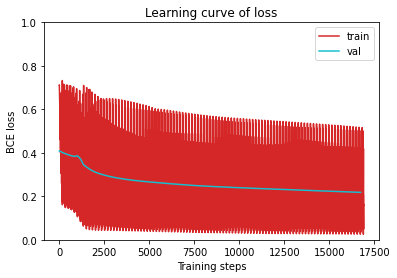

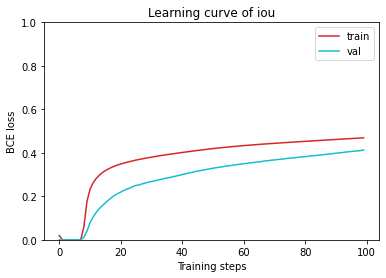

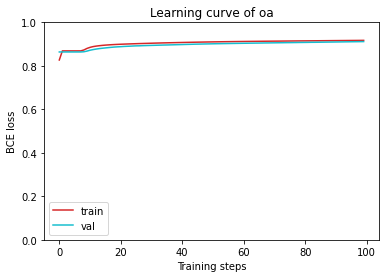

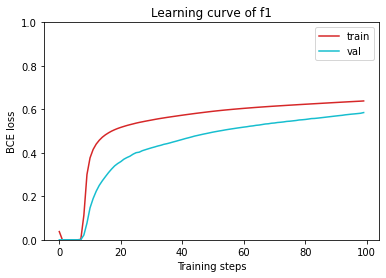

In [ ]:
import matplotlib.pyplot as plt # 用来绘制曲线
from matplotlib.pyplot import figure

def plot_learning_curve(loss_record, title='',y_max=1):
  total_steps = len(loss_record[f'train_{title}'])
  x_1 = range(total_steps)
  x_2 = x_1[::len(loss_record[f'train_{title}']) // len(loss_record[f'val_{title}'])]
  figure(figsize=(6, 4))
  plt.plot(x_1, loss_record[f'train_{title}'], c='tab:red', label='train')
  plt.plot(x_2, loss_record[f'val_{title}'], c='tab:cyan', label='val')
  plt.ylim(0.0, y_max)
  plt.xlabel('Training steps')
  plt.ylabel('BCE loss')
  plt.title('Learning curve of {}'.format(title))
  plt.legend()
  plt.show()

plot_learning_curve(result[0],"loss",1) # loss的变化曲线
plot_learning_curve(result[1],"iou",1) # iou的变化曲线
plot_learning_curve(result[2],"oa",1) # oa的变化曲线
plot_learning_curve(result[3],"f1",1) # f1的变化曲线

执行测试

In [ ]:
checkPoint=torch.load("/content/models/model.pth.ckpt")
model.load_state_dict(checkPoint)
test_loader = data.DataLoader(test_set,batch_size = 1, shuffle=True, num_workers = 1) 
test(test_loader,model) # 下面会提示，UserWarning: *** is a low contrast image，不用管它
# 执行完成后，可以从左侧下载预测结果(pre.csv)，并将其提交到Kaggle上，Kaggle会反馈给你测试集的评分

Valid Mode:   0% 0/810 [00:00<?, ? uttr/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: pre/22978975_15_3_1.png is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: pre/23579095_15_3_1.png is a low contrast image
Valid Mode:   0% 2/810 [00:00<00:44, 17.99 uttr/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: pre/23578990_15_1_0.png is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: pre/24029035_15_0_1.png is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: pre/23879020_15_0_0.png is a low contrast image
/usr/local/lib/python3.7

## 你需要做什么

**基本要求**


*   弄明白这些代码都在干什么



**中等要求**


*   解释模型：请试图解释本次作业中MyCNN()模型背后蕴含的思想


*   参数调整：在主程序中，有一个config变量，它存储了我们的很多超参数，如learning rate，batch size等，调整他们会改进模型的精度吗。关于优化器(optimizer)，我们使用的是SGD，有没有其它的优化器可以使用呢，这些优化器里的超参数（如momentum）需要怎么设置呢？


*   数据增强：数据增强也叫数据扩增，意思是在不实质性的增加数据的情况下，让有限的数据产生等价于更多数据的价值。对于图像来说，常见的数据增强包括旋转、平移、缩放等。你可以实现这些数据增强吗？实现这些数据增强会提升模型的泛化性能吗？

*   批标准化：批标准化（batchnorm）是一种用于改善人工神经网络的性能和稳定性的技术，被广泛用在现代语义分割模型中，本次作业我们使用的基线模型并不包含批标准化，你会把它加入到我们的基线模型中吗？在我们的任务中，它会提升模型的性能吗？为什么？

**终极要求**

*   自己对模型的结构进行修改，或直接引入更先进的模型，从而提高最终精度

*   建筑物轮廓信息：不同于其他的地物，建筑物具有非常正则的几何形态，因此，模型对于边缘（即轮廓）的感知对于建筑物的预测精度有较大的影响。你有什么办法提高模型对建筑物边缘的预测精度吗（提示：最简单的办法是将轮廓信息做为监督信息的一种）

*   其它：发挥你的想法，尽可能地减小测试集误差，并解释为什么